# Chapter 4: Statistics

**Mathematics for Machine Learning (2025)**
Teaching Team

Lecturers: 
- Eleonora Giunchiglia (Department of Electrical and Electronic Engineering)
- Felipe Tobar (Department of Mathematics)

Graduate Teaching Assistants (GTAs)
- Camilo Carvajal Reyes (Department of Mathematics)
- Joshua Ong (Department of Electrical and Electronic Engineering)

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 15,
    "axes.titlesize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
    "font.family": "serif",
})

## Examples for lecture notes

### Maximum likelohood estimator for a Bernoulli model

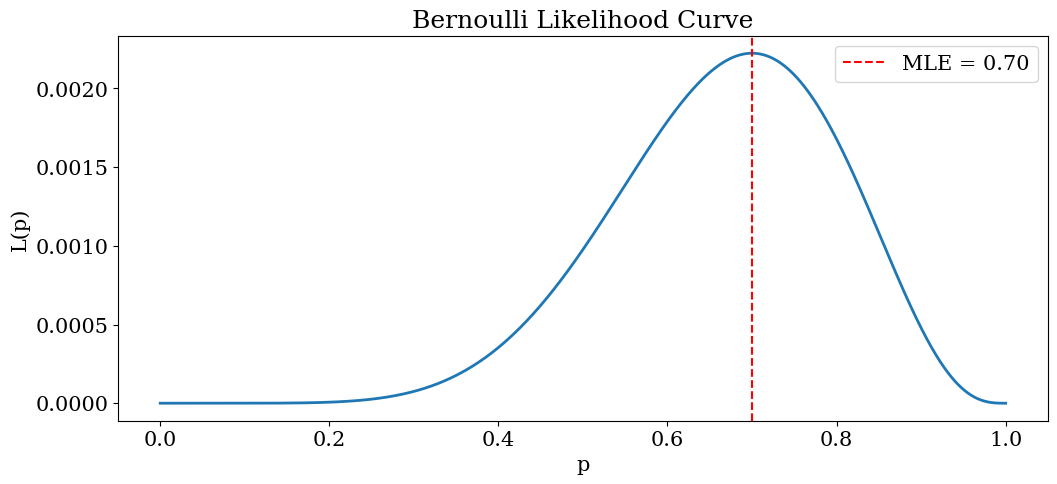

In [2]:
import numpy as np

k = 7   # number of successes
N = 10  # number of trials
p = np.linspace(1e-6, 1-1e-6, 1000)

L = (p**k) * ((1-p)**(N-k))
p_hat = k/N

fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(p, L, linewidth=2)
ax1.axvline(p_hat, color='red', linestyle='--', label=f"MLE = {p_hat:.2f}")
ax1.set_title("Bernoulli Likelihood Curve")
ax1.set_xlabel("p")
ax1.set_ylabel("L(p)")
ax1.legend()
ax1.grid(False)
plt.savefig('../img/stats_bernoulli_mle.pdf',bbox_inches='tight');


### Bayesian inference and posterior distribution

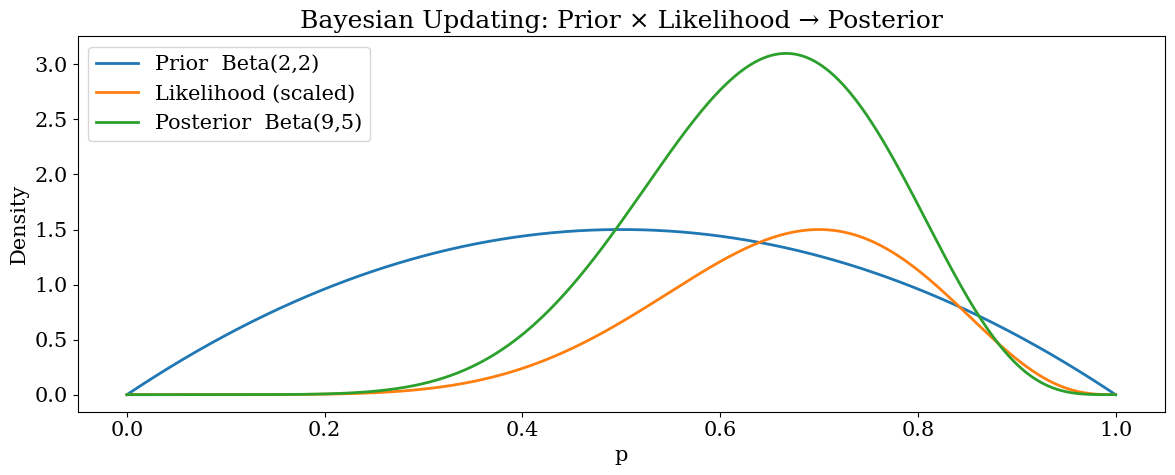

In [3]:
from scipy.stats import beta

# Prior parameters
alpha, beta_param = 2, 2   # Prior: Beta(2,2)

# Data: k successes out of N
k, N = 7, 10

# Parameter grid
p = np.linspace(1e-6, 1-1e-6, 1000)

# Prior
prior = beta.pdf(p, alpha, beta_param)

# Likelihood (unnormalised)
likelihood = (p**k) * (1-p)**(N-k)

# Normalise likelihood to plot on same scale
likelihood_scaled = likelihood / np.max(likelihood) * np.max(prior)

# Posterior: Beta(alpha+k, beta+N-k)
posterior = beta.pdf(p, alpha + k, beta_param + N - k)

plt.figure(figsize=(12,5))
plt.plot(p, prior, label=f"Prior  Beta({alpha},{beta_param})", linewidth=2)
plt.plot(p, likelihood_scaled, label="Likelihood (scaled)", linewidth=2)
plt.plot(p, posterior, label=f"Posterior  Beta({alpha+k},{beta_param+N-k})", linewidth=2)

plt.title("Bayesian Updating: Prior × Likelihood → Posterior")
plt.xlabel("p")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('../img/stats_beta_posterior.pdf',bbox_inches='tight')

### Posterior concentration with Dirichlet prior

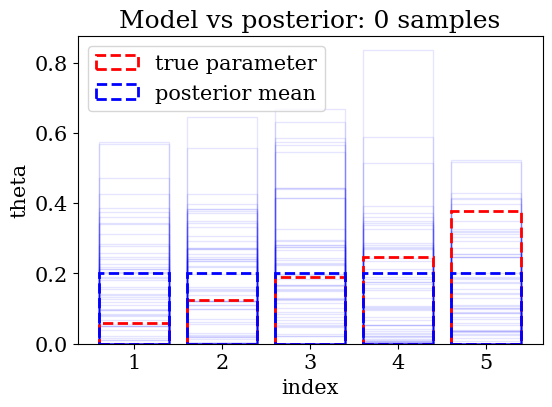

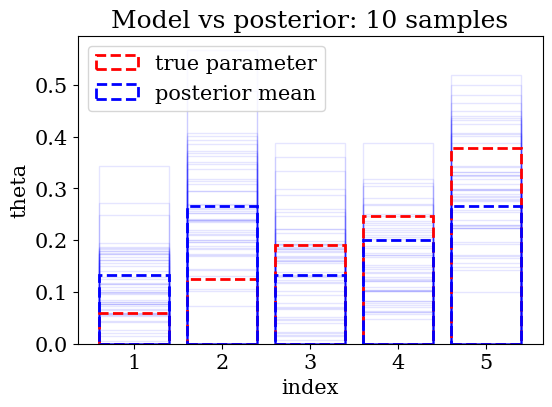

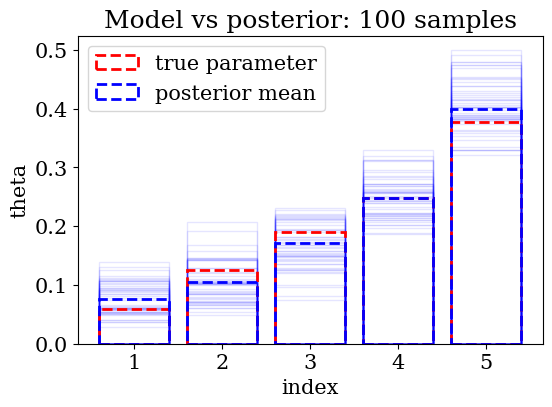

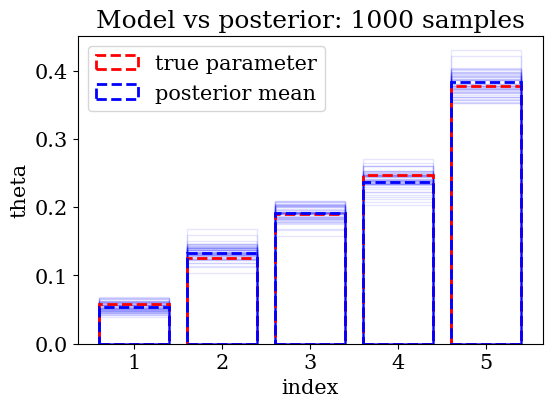

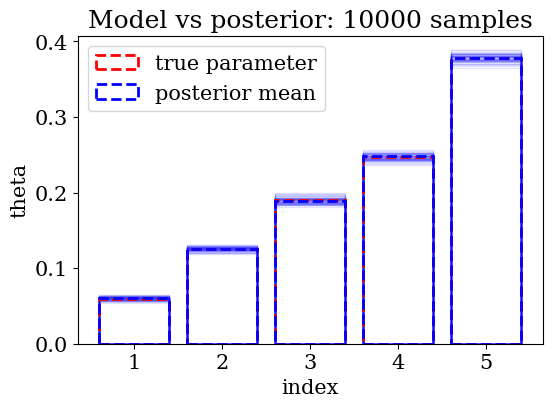

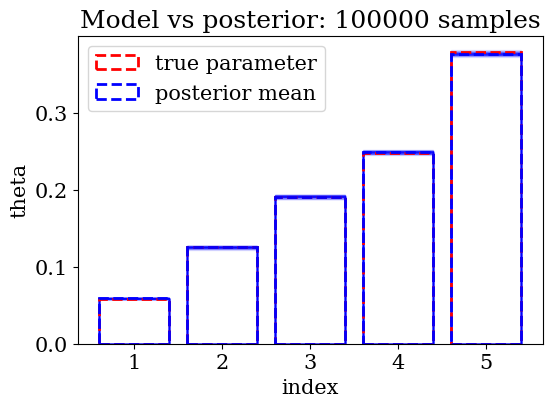

In [4]:
import numpy as np
import matplotlib.pyplot as plt

k = 5  # number of classes
alpha = 10*np.array(np.arange(k)+1)
theta = np.random.dirichlet(alpha)

for n in [0,10,100,1000,10000,100000]:
    x = np.random.multinomial(n,theta)
    new_alpha = np.ones(k) + x
    new_theta = np.random.dirichlet(new_alpha, 100)
    plt.figure(figsize=(6,4))
    for i in range(50):
        plt.bar(np.arange(k)+1, new_theta[i,:], alpha=0.1, edgecolor='b', color='None');
    plt.bar(np.arange(k)+1, theta, lw=2, linestyle ='--', edgecolor='r', color='None', label = 'true parameter');
    plt.bar(np.arange(k)+1, new_alpha/np.sum(new_alpha), lw=2, linestyle ='--', edgecolor='blue', color='None', label = 'posterior mean');
    plt.legend()
    plt.title(f'Model vs posterior: {n} samples')
    plt.xlabel('index')
    plt.ylabel('theta')
    plt.savefig(f'../img/stats_post_dirichlet_{n}.pdf',bbox_inches='tight');

### Bayes posterior vs plug-in prediction

In [5]:
# True parameters
mu_true = 2.0
sigma2 = 2.0   # known variance

# Prior on mu
mu0 = 0.0
tau0_sq = 4.0  # prior variance (quite wide)


np.random.seed(42)

# Observed data (small N to highlight difference)
N = 5
x_data = np.random.normal(mu_true, np.sqrt(sigma2), size=N)

# -----------------------------
# Compute MLE and Bayesian posterior
# -----------------------------

# Plug-in (MLE) estimate of mu
mu_mle = np.mean(x_data)

# Posterior for mu in Normal-Normal model
# tau_N^2 = 1 / (N/sigma2 + 1/tau0_sq)
tauN_sq = 1.0 / (N/sigma2 + 1.0/tau0_sq)
muN = tauN_sq * (np.sum(x_data)/sigma2 + mu0/tau0_sq)

# Predictive distributions for a new x_new
# Plug-in predictive: N(mu_mle, sigma2)
# Bayesian predictive: N(muN, sigma2 + tauN_sq)
xs = np.linspace(mu_true - 4, mu_true + 4, 400)

def normal_pdf(x, mean, var):
    return 1.0/np.sqrt(2*np.pi*var) * np.exp(-(x-mean)**2/(2*var))

plugin_pred = normal_pdf(xs, mu_mle, sigma2)
bayes_pred = normal_pdf(xs, muN, sigma2 + tauN_sq)

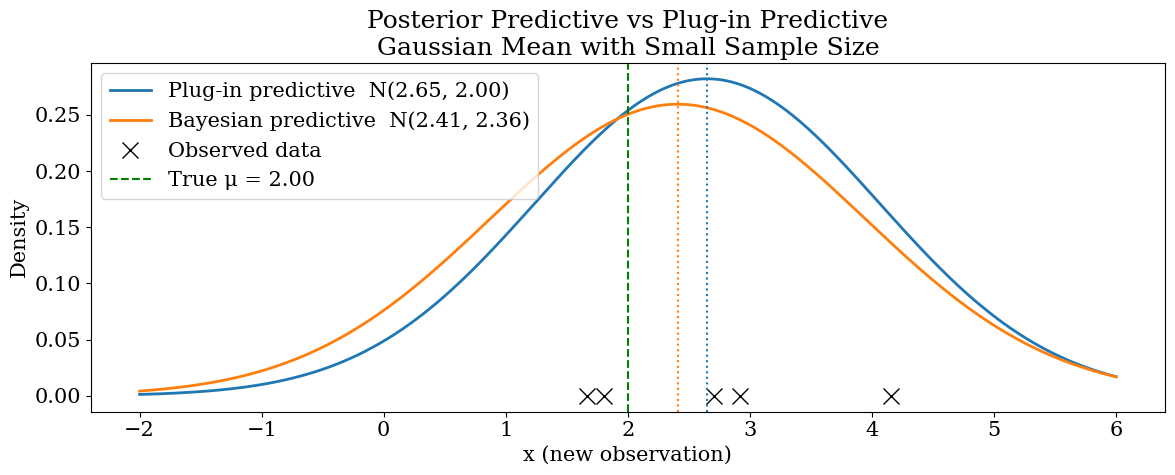

In [6]:
fig, ax = plt.subplots(figsize=(12,5))

# Plot predictive densities
ax.plot(xs, plugin_pred, label=f"Plug-in predictive  N({mu_mle:.2f}, {sigma2:.2f})", lw=2)
ax.plot(xs, bayes_pred, label=f"Bayesian predictive  N({muN:.2f}, {(sigma2+tauN_sq):.2f})", lw=2)

# Plot observed data as rug marks on x-axis
ax.plot(x_data, np.zeros_like(x_data), 'x', color='black', markersize=12, label='Observed data')

# Plot vertical lines for mu_true, mu_mle, muN
ax.axvline(mu_true, color='green', linestyle='--', lw=1.5, label=f"True μ = {mu_true:.2f}")
ax.axvline(mu_mle, color='C0', linestyle=':', lw=1.5)
ax.axvline(muN, color='C1', linestyle=':', lw=1.5)

ax.set_title("Posterior Predictive vs Plug-in Predictive\nGaussian Mean with Small Sample Size")
ax.set_xlabel("x (new observation)")
ax.set_ylabel("Density")
ax.legend()
ax.grid(False)
plt.tight_layout()
plt.savefig('../img/stats_posterior_plugin.pdf',bbox_inches='tight')

## Exercise

Let $X$ be a random variable in $\mathbb{R}^d$ and $Y$ a real-valued random variable. Consider the linear regression model:

$$ Y = \beta_0 + \beta^T X + \epsilon,\quad \epsilon \sim \mathcal{N}(0, \sigma^2),$$

with $\beta = (\beta_1, \dots, \beta_d)^T$. We assume $\sigma^2$ is known. We are interested in the Bayesian estimation of the parameters $\beta = (\beta_0, \beta_1, \dots, \beta_d)$. We assume that the distribution of $X$ does not depend on $\beta$. Let $(x_i, y_i)_{1 \le i \le N}$ be data.

> Exercise: simulate the data considering $X\sim\mathcal{U}[0,1]$ and for $\beta_0=0$ and $\beta=1$. Plot the resulting r.v. $Y$ for different noise levels $\sigma^2$.

> Exercise: Show that the **maximum a posteriori** (MAP) estimator with a constant uniform prior (which does not depend on $\theta$) is equivalent to the maximum likelihood estimator.

...

Suppose we use the following prior:

$$ p(\beta) = \frac{1}{\sqrt{2\pi}\tau} e^{-\frac{\beta^2}{2\tau^2}}.$$

> Exercise: Compute the maximum a posteriori estimator. Identify which known estimator it corresponds to. Implement a method that returns the MAP given the simulated data.

Consider the cases:

- $\tau \to \infty$
- $\tau \to 0$

> Exercise: Discuss what happens in each case, both in terms of the estimator found and in Bayesian terms (that is, think about the shape of the priors in both cases). Choose certain values of $\tau$ in both regimes, as well as a reference value $\tau=1$. Plot the priors and posterior in each case and comment.